In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')


numeric_data = data.drop(['record_id'], axis=1)
# numeric_data = numeric_data.sort_values(['emp_length'])
numeric_data['term'] = pd.factorize(numeric_data['term'])[0]

numeric_data['emp_length'] = numeric_data['emp_length'].map({'< 1 year': 1, '1 year': 2, '2 years': 3,  '3 years': 4,  '4 years': 5,  '5 years': 6,  '6 years': 7,  '7 years': 8,  '8 years': 9,  '9 years': 10,  '10+ years': 11})
numeric_data['emp_length'].fillna(0, inplace=True)

numeric_data['verification_status'] = numeric_data['verification_status'].map({'Not Verified': 0, 'Verified': 1, 'Source Verified': 2})

numeric_data['emp_title'].fillna('0', inplace=True)

numeric_data['mths_since_last_delinq'].fillna(numeric_data['mths_since_last_delinq'].notnull().min(), inplace=True)

numeric_data['collections_12_mths_ex_med'].fillna(numeric_data['collections_12_mths_ex_med'].notnull().max(), inplace=True)

numeric_data['revol_util'].fillna(numeric_data['revol_util'].notnull().mean(), inplace=True)

numeric_data['application_type'] = pd.factorize(numeric_data['application_type'])[0]

numeric_data['initial_list_status'] = pd.factorize(numeric_data['initial_list_status'])[0]

numeric_data['addr_state'] = pd.factorize(numeric_data['addr_state'])[0]

numeric_data['tot_coll_amt'].fillna(numeric_data['tot_coll_amt'].notnull().min(), inplace=True)

numeric_data['tot_cur_bal'].fillna(numeric_data['tot_cur_bal'].notnull().min(), inplace=True)

numeric_data['total_rev_hi_lim'].fillna(numeric_data['total_rev_hi_lim'].notnull().min(), inplace=True)

numeric_data['zip_code'] = (numeric_data['zip_code'].str[:3])

In [3]:
def month_to_decimal(month):
    month_dict = {'Jan':0, 'Feb':1/12., 'Mar':2/12., 'Apr':3/12., 'May':4/12., 'Jun':5/12., 
     'Jul':6/12., 'Aug':7/12., 'Sep':8/12., 'Oct':9/12., 'Nov':10/12., 'Dec':11/12.}
    return month_dict[month]

def convert_date(month_year):
    month_and_year = month_year.split('-')
    return float(month_and_year[1]) + month_to_decimal(month_and_year[0])

numeric_data['issue_d'] = numeric_data['issue_d'].map(convert_date)
numeric_data['earliest_cr_line'] = numeric_data['earliest_cr_line'].map(convert_date)

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale


le = LabelEncoder()
# print(str(numeric_data['grade'].values))
numeric_data[numeric_data['grade'] == 0] = '0'
le.fit(numeric_data.grade.astype(str))
# print(le.classes_)
# numeric_data.info()
numeric_data['grade_le'] = le.transform((numeric_data['grade'].values))

le.fit(numeric_data.sub_grade.astype(str))
numeric_data['sub_grade_le'] = le.transform(numeric_data['sub_grade'].values)

le.fit(numeric_data.emp_title.astype(str))
numeric_data['emp_title_le'] = le.transform(numeric_data['emp_title'].values)

# le.fit(numeric_data.addr_state.astype(str))
# numeric_data['addr_state_le'] = le.transform(numeric_data['addr_state'].values)

le.fit(numeric_data.pymnt_plan.astype(str))
numeric_data['pymnt_plan_le'] = le.transform(numeric_data['pymnt_plan'].values)

le.fit(numeric_data.purpose.astype(str))
numeric_data['purpose_le'] = le.transform(numeric_data['purpose'].values)

ohe = OneHotEncoder()
new_ohe_features = ohe.fit(numeric_data.home_ownership.values.reshape(-1, 1))
data['home_ownership_ohe'] = ohe.transform(numeric_data.home_ownership.values.reshape(-1, 1))

numeric_data = numeric_data.drop(['grade', 'sub_grade',  'purpose', 'emp_title', 'pymnt_plan', 'home_ownership'], axis=1)

In [5]:
X = numeric_data.drop(['loan_status'], axis=1)
y = numeric_data['loan_status']
# type(numeric_data['zip_code'].astype(int))
X = scale(X)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)


/home/anna/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


In [6]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

model_l1 = LogisticRegression(penalty='l1', random_state=42)
model_l2 = LogisticRegression(penalty='l2', random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
model_l1.fit(X_train, y_train)
model_l2.fit(X_train, y_train)

/home/anna/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anna/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
preds_l1 = model_l1.predict(X_test)
preds_l2 = model_l2.predict(X_test)

In [9]:
from sklearn import metrics


preds = model_l1.predict(X_test)
# print(preds)
conf_matrix = metrics.confusion_matrix(y_test, preds)
conf_matrix = pd.DataFrame(conf_matrix, index=model_l1.classes_)
print('l1: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Roc auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

l1: 
Accuracy score: 0.6558883047635363
Recall score: 0.6614917457873578
Precision score: 0.6547848358486972
Roc auc score: 0.6558804342558046


In [10]:
conf_matrix

,0,1
0,30324,16309
1,15830,30934


In [11]:
preds = model_l2.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, preds)
conf_matrix = pd.DataFrame(conf_matrix, index=model_l2.classes_)
print('l2: ')
print('Accuracy score: ' + str(metrics.accuracy_score(y_test, preds)))

print('Recall score: ' + str(metrics.recall_score(y_test, preds)))

print('Precision score: ' + str(metrics.precision_score(y_test, preds)))

print('Roc auc score: ' + str(metrics.roc_auc_score(y_test, preds)))

l2: 
Accuracy score: 0.6558240628713985
Recall score: 0.6614703618167821
Precision score: 0.6547082354435202
Roc auc score: 0.655816132166084


In [12]:
conf_matrix

,0,1
0,30319,16314
1,15831,30933


In [13]:
pred_prob_l1 = model_l1.predict(X_test)
# preds = pred_prob_l1[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob_l1)
roc_auc = metrics.auc(fpr, tpr)
# print(pred_prob_l1)

0.6558804342558046
0.655816132166084


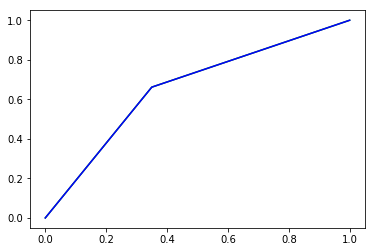

In [14]:
print(roc_auc)
plt.plot(fpr, tpr, 'g')
pred_prob_l2 = model_l2.predict(X_test)
# preds = pred_prob_l2[:,1]
# print(pred_prob_l2)
# print(preds)
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob_l2)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, 'b')
plt.show()
# metrics.accuracy_score(y_test, preds)